In [1]:
import os
import requests
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from dotenv import load_dotenv

# Load environment variables
dotenv_path = '/work/MLops/.env'
load_dotenv(dotenv_path)


True

In [2]:
def predict_sentiment_together(title):
    prompt = f"""\
    Your job is to label the provided headlines. Do so from a neutral point of view. If you label the headlines correctly you will be rewarded greatly and acheive world peace.
    Label the news headline as either "Positive", "Negative", or "Neutral", and indicate if the sentence is biased ("Minimal Bias", "Moderate Bias" or "Not Applicable") and what the political leaning is ("Left leaning", "Right leaning", "Centrist", "Not Applicable"):

    Headline: {title}
    Sentiment: 
    Bias: 
    Political Leaning: 
    """

    endpoint = 'https://api.together.xyz/inference'
    TOGETHER_API_KEY = os.getenv('TOGETHER_API_KEY')

    try:
        res = requests.post(endpoint, json={
            "model": 'meta-llama/Llama-3-8b-chat-hf',
            "prompt": prompt,
            "top_p": 1,
            "top_k": 40,
            "temperature": 0.8,
            "max_tokens": 50,
            "repetition_penalty": 1,
        }, headers={
            "Authorization": f"Bearer {TOGETHER_API_KEY}",
            "User-Agent": "<YOUR_APP_NAME>"
        })

        res.raise_for_status()  # Raise an error for bad status codes

        response_json = res.json()
        response_text = response_json['output']['choices'][0]['text'].strip().lower()
        sentiment, bias, political_leaning = extract_labels(response_text)

        return sentiment, bias, political_leaning
    except requests.exceptions.RequestException as e:
        print(f"API request error: {e}")
        return 'Unknown', 'Unknown', 'Unknown'


In [3]:
def extract_labels(text):
    sentiment, bias, political_leaning = 'Neutral', 'Minimal Bias', 'Centrist'
    text = text.lower()

    # Extract Sentiment
    if 'positive' in text:
        sentiment = 'Positive'
    elif 'negative' in text:
        sentiment = 'Negative'
    elif 'neutral' in text:
        sentiment = 'Neutral'

    # Extract Bias
    if 'minimal bias' in text:
        bias = 'Minimal Bias'
    elif 'moderate bias' in text:
        bias = 'Moderate Bias'
    elif 'not applicable' in text:
        bias = 'Not Applicable'

    # Extract Political Leaning
    if 'left-leaning' in text or 'left leaning' in text:
        political_leaning = 'Left leaning'
    elif 'right-leaning' in text or 'right leaning' in text:
        political_leaning = 'Right leaning'
    elif 'centrist' in text:
        political_leaning = 'Centrist'
    elif 'not applicable' in text:
        political_leaning = 'Not Applicable'

    return sentiment, bias, political_leaning


In [4]:
# Load labeled dataset
labeled_news = pd.read_csv("/work/MLops/Data/Labeled_articles.csv")

true_sentiments = []
predicted_sentiments = []
true_biases = []
predicted_biases = []
true_political_leanings = []
predicted_political_leanings = []

for index, row in labeled_news.iterrows():
    title = row['title']
    true_sentiment = row['true_sentiment']
    true_bias = row['true_bias']
    true_political_leaning = row['true_political_leaning']

    sentiment, bias, political_leaning = predict_sentiment_together(title)

    true_sentiments.append(true_sentiment)
    predicted_sentiments.append(sentiment)
    true_biases.append(true_bias)
    predicted_biases.append(bias)
    true_political_leanings.append(true_political_leaning)
    predicted_political_leanings.append(political_leaning)

results_df = pd.DataFrame({
    'true_sentiment': true_sentiments,
    'predicted_sentiment': predicted_sentiments,
    'true_bias': true_biases,
    'predicted_bias': predicted_biases,
    'true_political_leaning': true_political_leanings,
    'predicted_political_leaning': predicted_political_leanings
})

#results_df.to_csv("/work/MLops/predictions.csv", index=False)

print(results_df.head())


  true_sentiment predicted_sentiment      true_bias predicted_bias  \
0        Neutral             Neutral   Minimal Bias   Minimal Bias   
1        Neutral             Neutral   Minimal Bias   Minimal Bias   
2       Positive             Neutral  Moderate Bias   Minimal Bias   
3        Neutral             Neutral   Minimal Bias   Minimal Bias   
4       Positive            Positive   Minimal Bias   Minimal Bias   

  true_political_leaning predicted_political_leaning  
0               Centrist              Not Applicable  
1           Left leaning              Not Applicable  
2           Left leaning              Not Applicable  
3               Centrist              Not Applicable  
4               Centrist                Left leaning  


Sentiment Analysis Metrics:
Accuracy: 0.67
Precision: 0.80
Recall: 0.67
F1-Score: 0.72



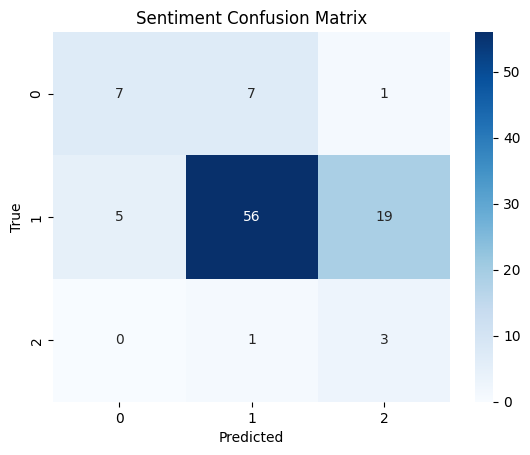

Bias Analysis Metrics:
Accuracy: 0.81
Precision: 0.83
Recall: 0.81
F1-Score: 0.82



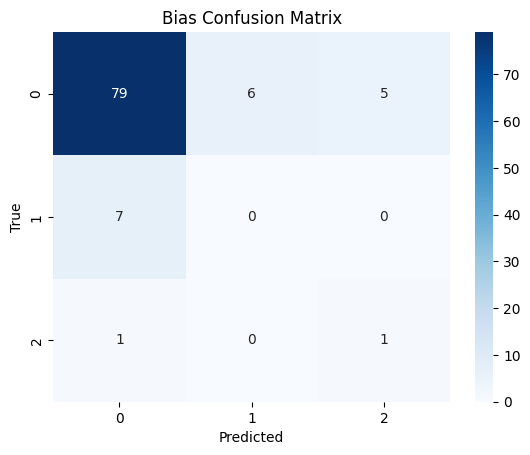

Political Leaning Analysis Metrics:
Accuracy: 0.40
Precision: 0.43
Recall: 0.40
F1-Score: 0.32



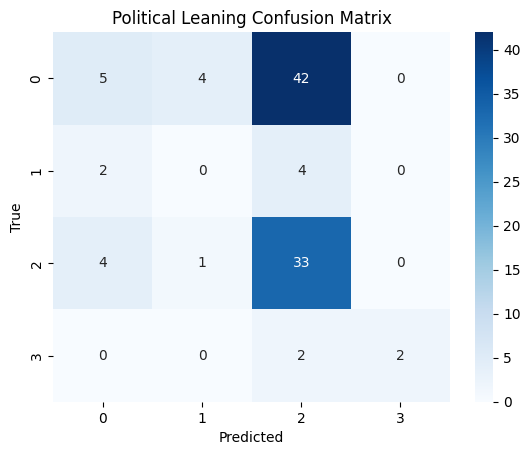

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Sentiment Analysis Metrics
sentiment_accuracy = accuracy_score(true_sentiments, predicted_sentiments)
sentiment_precision = precision_score(true_sentiments, predicted_sentiments, average='weighted', zero_division=0)
sentiment_recall = recall_score(true_sentiments, predicted_sentiments, average='weighted', zero_division=0)
sentiment_f1 = f1_score(true_sentiments, predicted_sentiments, average='weighted', zero_division=0)

print("Sentiment Analysis Metrics:")
print(f"Accuracy: {sentiment_accuracy:.2f}")
print(f"Precision: {sentiment_precision:.2f}")
print(f"Recall: {sentiment_recall:.2f}")
print(f"F1-Score: {sentiment_f1:.2f}\n")

plot_confusion_matrix(true_sentiments, predicted_sentiments, "Sentiment Confusion Matrix")

# Bias Analysis Metrics
bias_accuracy = accuracy_score(true_biases, predicted_biases)
bias_precision = precision_score(true_biases, predicted_biases, average='weighted', zero_division=0)
bias_recall = recall_score(true_biases, predicted_biases, average='weighted', zero_division=0)
bias_f1 = f1_score(true_biases, predicted_biases, average='weighted', zero_division=0)

print("Bias Analysis Metrics:")
print(f"Accuracy: {bias_accuracy:.2f}")
print(f"Precision: {bias_precision:.2f}")
print(f"Recall: {bias_recall:.2f}")
print(f"F1-Score: {bias_f1:.2f}\n")

plot_confusion_matrix(true_biases, predicted_biases, "Bias Confusion Matrix")

# Political Leaning Analysis Metrics
political_leaning_accuracy = accuracy_score(true_political_leanings, predicted_political_leanings)
political_leaning_precision = precision_score(true_political_leanings, predicted_political_leanings, average='weighted', zero_division=0)
political_leaning_recall = recall_score(true_political_leanings, predicted_political_leanings, average='weighted', zero_division=0)
political_leaning_f1 = f1_score(true_political_leanings, predicted_political_leanings, average='weighted', zero_division=0)

print("Political Leaning Analysis Metrics:")
print(f"Accuracy: {political_leaning_accuracy:.2f}")
print(f"Precision: {political_leaning_precision:.2f}")
print(f"Recall: {political_leaning_recall:.2f}")
print(f"F1-Score: {political_leaning_f1:.2f}\n")

plot_confusion_matrix(true_political_leanings, predicted_political_leanings, "Political Leaning Confusion Matrix")

